In [30]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Normalization
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import json

laps_df = pd.read_pickle('../data/preprocessed_laps.pkl')

laps_df.head()

,Driver,LapTime,SpeedAfterSector1,SpeedAfterSector2,SpeedAtFinishLine,IsPersonalBest,FreshTyre,Team,Humidity,Rainfall,...,Pressure_Category_Low,Pressure_Category_Normal,AirTemp_Category_Cold,AirTemp_Category_Normal,AirTemp_Category_Hot,AirTemp_Category_Very Hot,TrackTemp_Category_Cold,TrackTemp_Category_Normal,TrackTemp_Category_Hot,TrackTemp_Category_Very Hot
1,VER,0.527426,0.477551,0.553648,0.560000,1,0,Red Bull Racing,0.065574,0,...,False,True,False,False,True,False,False,True,False,False
3,VER,0.527460,0.481633,0.553648,0.560000,0,0,Red Bull Racing,0.065574,0,...,False,True,False,False,True,False,False,True,False,False
5,VER,0.527630,0.485714,0.557940,0.565714,0,0,Red Bull Racing,0.065574,0,...,False,True,False,False,True,False,False,True,False,False
6,VER,0.528226,0.489796,0.557940,0.565714,0,0,Red Bull Racing,0.065574,0,...,False,True,False,False,True,False,False,True,False,False
11,VER,0.537936,0.493878,0.566524,0.560000,0,0,Red Bull Racing,0.049180,0,...,False,True,False,False,True,False,False,True,False,False


In [31]:
categorical_features = ['Driver', 'Team']
numerical_features = laps_df.drop(columns=categorical_features + ['LapTime']).columns.tolist()

In [32]:
label_encoder_driver = LabelEncoder()
label_encoder_team = LabelEncoder()
laps_df['Driver_encoded'] = label_encoder_driver.fit_transform(laps_df['Driver'])
laps_df['Team_encoded'] = label_encoder_team.fit_transform(laps_df['Team'])

In [33]:
X_driver = laps_df['Driver_encoded'].values
X_team = laps_df['Team_encoded'].values
X_numerical = laps_df[numerical_features].values
y = laps_df['LapTime'].values

In [34]:
X_driver = X_driver.astype(np.int32)
X_team = X_team.astype(np.int32)
X_numerical = X_numerical.astype(np.float32)
y = y.astype(np.float32)
X_train_driver, X_test_driver, X_train_team, X_test_team, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_driver, X_team, X_numerical, y, test_size=0.2, random_state=42
)

In [35]:
input_driver = Input(shape=(1,), name='Driver_Input')
input_team = Input(shape=(1,), name='Team_Input')
input_numerical = Input(shape=(X_train_num.shape[1],), name='Numerical_Input')

In [36]:
embedding_driver = Embedding(input_dim=laps_df['Driver_encoded'].nunique(), output_dim=10)(input_driver)
embedding_team = Embedding(input_dim=laps_df['Team_encoded'].nunique(), output_dim=5)(input_team)

embedding_driver_flat = Flatten()(embedding_driver)
embedding_team_flat = Flatten()(embedding_team)

In [37]:
combined_features = Concatenate()([embedding_driver_flat, embedding_team_flat, input_numerical])


In [38]:
x = layers.Dense(128, activation='relu')(combined_features)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1)(x)

In [39]:
model = models.Model(inputs=[input_driver, input_team, input_numerical], outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit([X_train_driver, X_train_team, X_train_num], y_train, epochs=100, batch_size=32, validation_split=0.2)

test_loss, test_mae = model.evaluate([X_test_driver, X_test_team, X_test_num], y_test)

Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0342 - mae: 0.1175 - val_loss: 0.0015 - val_mae: 0.0280
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0014 - mae: 0.0257 - val_loss: 8.7427e-04 - val_mae: 0.0215
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 7.4675e-04 - mae: 0.0202 - val_loss: 7.1080e-04 - val_mae: 0.0192
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 5.6190e-04 - mae: 0.0171 - val_loss: 6.2035e-04 - val_mae: 0.0175
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 4.4676e-04 - mae: 0.0157 - val_loss: 5.3172e-04 - val_mae: 0.0160
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 4.1521e-04 - mae: 0.0153 - val_loss: 5.1136e-04 - val_mae: 0.0153
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 3.3956e-04 - mae: 0.0139 - val_loss: 4.9245e-04 - val_mae: 0.0155
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 3.4422e-04 - mae: 0.0140 - val_loss: 5.6797e-04 

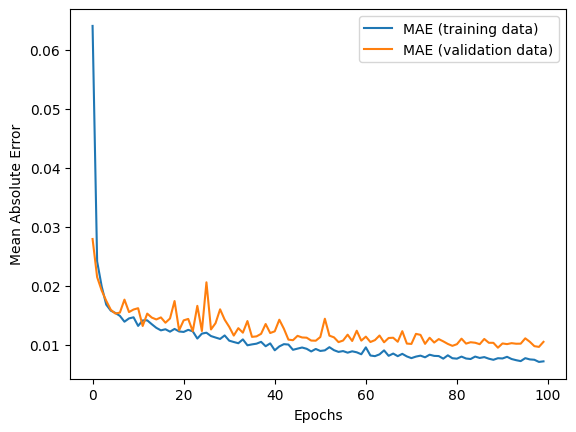

test_loss: 0.0002131419605575502
test_mae: 0.009823537431657314


In [40]:
plt.plot(history.history['mae'], label='MAE (training data)')
plt.plot(history.history['val_mae'], label='MAE (validation data)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()
print(f"test_loss: {test_loss}")
print(f"test_mae: {test_mae}")

In [41]:
def predict(row):
    input_data = pd.DataFrame([row])
    input_data['Driver_encoded'] = label_encoder_driver.transform(input_data['Driver'])
    input_data['Team_encoded'] = label_encoder_team.transform(input_data['Team'])
    X_driver = input_data['Driver_encoded'].values.astype(np.int32)
    X_team = input_data['Team_encoded'].values.astype(np.int32)
    X_numerical = input_data[numerical_features].values.astype(np.float32)
    prediction = model.predict([X_driver, X_team, X_numerical])
    return prediction[0][0]



In [54]:
with open('normalised_max_min.json') as json_file:
    normalised_max_min = json.load(json_file)

row = laps_df.drop(columns=['LapTime']).iloc[99]
predicted_lap_time = predict(row)
print((predicted_lap_time*(normalised_max_min['LapTime']['max']-normalised_max_min['LapTime']['min'])) + normalised_max_min['LapTime']['min'])
print((laps_df.iloc[99]['LapTime']*(normalised_max_min['LapTime']['max']-normalised_max_min['LapTime']['min'])) + normalised_max_min['LapTime']['min'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
98.24556896591186
98.361


In [63]:
model.save('lap-time-model.keras')

In [76]:
joblib.dump(label_encoder_driver, '../models/led.pkl')
joblib.dump(label_encoder_team, '../models/let.pkl')

['../models/let.pkl']

In [74]:
a = ['VER', 0.47755102040816333, 0.5536480686695279, 0.56, 1, 0,
       'Red Bull Racing', 0.0655737704918033, 0, 0.4366197183098592,
       0.45299145299145316, 0.6071919934621487, 1, 1, 0, 0, 0, 0, 0,
       0.13098107071941528, 0.0, False, False, False, True, False, False,
       True, False, False, False, True, False, False, True, False, False,
       True, False, False, 20, 8]

dict_ = {}
for i,j in enumerate(a):
    dict_[laps_df.drop(columns=["LapTime"]).columns.tolist()[i]] = j
dict_

{'Driver': 'VER',
 'SpeedAfterSector1': 0.47755102040816333,
 'SpeedAfterSector2': 0.5536480686695279,
 'SpeedAtFinishLine': 0.56,
 'IsPersonalBest': 1,
 'FreshTyre': 0,
 'Team': 'Red Bull Racing',
 'Humidity': 0.0655737704918033,
 'Rainfall': 0,
 'Speed_min': 0.4366197183098592,
 'RPM_max': 0.45299145299145316,
 'RPM_std': 0.6071919934621487,
 'ContainsTrackStatus1': 1,
 'ContainsTrackStatus2': 1,
 'ContainsTrackStatus4': 0,
 'ContainsTrackStatus6': 0,
 'ContainsTrackStatus7': 0,
 'SpeedAfterSector1IsFast': 0,
 'SpeedAfterSector2IsFast': 0,
 'combo_speed_max_speed_std': 0.13098107071941528,
 'combo_stint_lap_number': 0.0,
 'Compound_HARD': False,
 'Compound_INTERMEDIATE': False,
 'Compound_MEDIUM': False,
 'Compound_SOFT': True,
 'DirectionOfWind_East': False,
 'DirectionOfWind_North': False,
 'DirectionOfWind_South': True,
 'DirectionOfWind_West': False,
 'Pressure_Category_Very Low': False,
 'Pressure_Category_Low': False,
 'Pressure_Category_Normal': True,
 'AirTemp_Category_Cold':

In [90]:
predict(pd.DataFrame(dict_, index=[0]).iloc[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


0.53428

In [86]:
pd.DataFrame(dict_, index=[0]).reset_index(drop=True)

,Driver,SpeedAfterSector1,SpeedAfterSector2,SpeedAtFinishLine,IsPersonalBest,FreshTyre,Team,Humidity,Rainfall,Speed_min,...,AirTemp_Category_Cold,AirTemp_Category_Normal,AirTemp_Category_Hot,AirTemp_Category_Very Hot,TrackTemp_Category_Cold,TrackTemp_Category_Normal,TrackTemp_Category_Hot,TrackTemp_Category_Very Hot,Driver_encoded,Team_encoded
0,VER,0.477551,0.553648,0.56,1,0,Red Bull Racing,0.065574,0,0.43662,...,False,False,True,False,False,True,False,False,20,8


In [72]:
laps_df.drop(columns=["LapTime"]).columns.tolist()[0]

'Driver'